In [1]:
import numpy as np

# Проверка одномерного умножения

In [2]:
def fast_tmv_mul(col_arr,
                 row_arr,
                 vec_arr,
                 n):
    """
    One-level fast toeplitz matrix to vector multiplication

    :param col_arr:
    :param row_arr:
    :param vec_arr:
    :param n:
    :return:
    """
    circulant_row = np.zeros((2 * n,)) + 0.0j
    x_arr = np.zeros((2 * n,)) + 0.0j

    circulant_row[:n] = row_arr[:n]
    circulant_row[(n + 1):(2 * n)] = col_arr[n:0:-1]

    x_arr[:n] = vec_arr[:n]

    circulant_row = np.fft.fft(circulant_row) * np.fft.fft(x_arr)
    circulant_row = np.fft.ifft(circulant_row)[:n]

    return circulant_row

In [3]:
def kernel(x, k=1):
    return np.exp(1j * k * x)/(4 * np.pi * x)

In [4]:
def wave(x, k, amplitude, sign):
    return amplitude * np.exp(sign * 1j * k * x)

In [5]:
from_x = 0
to_x = 1
n = 20
k=2
grid = np.linspace(from_x, to_x, n+1)
h = grid[1] - grid[0]
grid = (grid[1:] + grid[:-1]) / 2
f_wave = wave(grid, k, amplitude=1.0, sign=-1.0)
g_array = np.zeros((n, n)) + 0.0j

for i in range(n-1):
    for j in range(i+1, n):
        g_array[i, j] = kernel(np.abs(grid[i] - grid[j])) * h
        g_array[j, i] = kernel(np.abs(grid[j] - grid[i])) * h

In [6]:
g_array @ f_wave

array([0.26024349-0.08473106j, 0.32816204-0.10655612j,
       0.35381784-0.13276141j, 0.3634933 -0.16040994j,
       0.36376576-0.18820449j, 0.35733847-0.21530648j,
       0.34566423-0.24107775j, 0.32968977-0.2649904j ,
       0.3101328 -0.2865866j , 0.28760474-0.30545707j,
       0.26267314-0.32122625j, 0.23589865-0.33353853j,
       0.20786235-0.34204062j, 0.17919372-0.34635362j,
       0.15060992-0.34602236j, 0.12298655-0.34041264j,
       0.09750939-0.32847601j, 0.07606619-0.30811034j,
       0.06257326-0.27388149j, 0.07063752-0.20311974j])

In [7]:
fast_tmv_mul(col_arr = g_array[:, 0],
             row_arr = g_array[0, :],
             vec_arr = f_wave, n = n)

array([0.26024349-0.08473106j, 0.32816204-0.10655612j,
       0.35381784-0.13276141j, 0.3634933 -0.16040994j,
       0.36376576-0.18820449j, 0.35733847-0.21530648j,
       0.34566423-0.24107775j, 0.32968977-0.2649904j ,
       0.3101328 -0.2865866j , 0.28760474-0.30545707j,
       0.26267314-0.32122625j, 0.23589865-0.33353853j,
       0.20786235-0.34204062j, 0.17919372-0.34635362j,
       0.15060992-0.34602236j, 0.12298655-0.34041264j,
       0.09750939-0.32847601j, 0.07606619-0.30811034j,
       0.06257326-0.27388149j, 0.07063752-0.20311974j])

# Проверка двумерного умножения

In [8]:
def fast_btmv_mul(col_arr,
                  row_arr,
                  vec_arr,
                  n, m):
    """

    :param col_arr:
    :param row_arr:
    :param vec_arr:
    :param n:
    :param m:
    :return:
    """
    circulant_matrix = np.zeros((2 * n, 2 * m)) + 0.0j
    x_arr = np.zeros((2 * n, 2 * m)) + 0.0j

    circulant_matrix[:n, :m] = row_arr[:n, :m]
    circulant_matrix[n + 1:2 * n, :m] = col_arr[n:0:-1, :m]
    circulant_matrix[:n, m + 1:2 * m] = col_arr[:n, m:0:-1]
    circulant_matrix[n + 1:2 * n, m + 1:2 * m] = col_arr[n:0:-1, m:0:-1]

    x_arr[:n, :m] = vec_arr[:n, :m]

    circulant_matrix = np.fft.fft2(circulant_matrix) * np.fft.fft2(x_arr)
    circulant_matrix = np.fft.ifft2(circulant_matrix)

    return circulant_matrix[:n, :m]

In [9]:
def wave_2d(x, k, amplitude, sign, orient):
    return amplitude * np.exp(sign * 1j * k * x.dot(orient))

In [10]:
from_x = 0
to_x = 1
from_y = -1
to_y = 1
n_x = 20
n_y = 30

grid_x = np.linspace(from_x, to_x, n_x+1)
grid_y = np.linspace(from_y, to_y, n_y+1)
grid_x = (grid_x[1:] + grid_x[:-1])/2
grid_y = (grid_y[1:] + grid_y[:-1])/2

grid_2d = np.stack(np.meshgrid(grid_x, grid_y)[::-1], axis=-1)
grid_2d = grid_2d.reshape(-1, 2, order="C")
print(grid_2d.shape)

print(grid_2d)

g_array_2d = np.zeros((n_x*n_y, n_x*n_y)) + 0.0j

k=2
orient = (1, 0.5)
orient = np.array(orient) / np.linalg.norm(orient, 2)

for i in range(n_x  * n_y - 1):
    for j in range(i+1, n_x * n_y):
        g_array_2d[i, j] = kernel(np.sqrt(np.sum((grid_2d[i] - grid_2d[j])**2)), k)
        g_array_2d[j, i] = kernel(np.sqrt(np.sum((grid_2d[j] - grid_2d[i])**2)), k)
        
f_wave_2d = wave_2d(grid_2d, k, 1, 1, orient)

(600, 2)
[[-0.96666667  0.025     ]
 [-0.96666667  0.075     ]
 [-0.96666667  0.125     ]
 ...
 [ 0.96666667  0.875     ]
 [ 0.96666667  0.925     ]
 [ 0.96666667  0.975     ]]


In [11]:
result_2d = g_array_2d @ f_wave_2d
result_2d_fft = fast_btmv_mul(col_arr = g_array_2d[0,:].reshape(n_y, n_x), 
                              row_arr = g_array_2d[:,0].reshape(n_y, n_x), 
                              vec_arr = f_wave_2d.reshape(n_y, n_x), 
                              n = n_y, m = n_x)

result_2d - result_2d_fft.reshape(-1,)

array([ 5.32907052e-15+3.28626015e-14j, -2.13162821e-14-3.19744231e-14j,
        1.77635684e-14+1.24344979e-14j, -3.55271368e-15+3.01980663e-14j,
       -7.10542736e-15+1.42108547e-14j, -7.10542736e-15+3.55271368e-15j,
        1.06581410e-14+9.41469125e-14j, -1.06581410e-14-4.44089210e-14j,
        2.84217094e-14-1.42108547e-14j, -7.10542736e-15-4.61852778e-14j,
       -3.55271368e-15+5.15143483e-14j, -4.97379915e-14+5.32907052e-14j,
        4.61852778e-14+2.22044605e-14j,  1.06581410e-14-7.10542736e-15j,
       -4.26325641e-14-2.66453526e-14j, -2.48689958e-14+5.19584376e-14j,
        1.06581410e-14+1.68753900e-14j,  1.42108547e-14+1.88737914e-15j,
       -1.06581410e-14-3.19744231e-14j, -2.48689958e-14-1.37667655e-14j,
        1.77635684e-14+0.00000000e+00j, -2.48689958e-14+1.06581410e-14j,
       -2.13162821e-14-2.13162821e-14j, -1.42108547e-14-5.15143483e-14j,
        1.42108547e-14+3.01980663e-14j, -1.77635684e-14+7.10542736e-15j,
       -2.48689958e-14+4.79616347e-14j, -3.55271368

C:\ProgramData\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


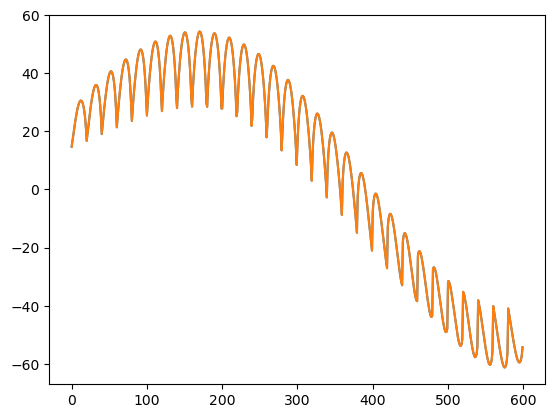

In [12]:
import matplotlib.pyplot as plt
plt.plot(result_2d)
plt.plot(result_2d_fft.reshape(-1,))

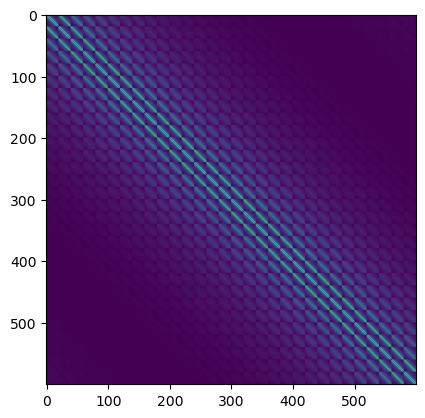

In [13]:
plt.imshow(g_array_2d.real)

# Проверка трехмерного умножения

In [14]:
def fast_bbtmv_mul(col_arr,
                   row_arr,
                   vec_arr,
                   n, m, k):
    """

    :param col_arr:
    :param row_arr:
    :param vec_arr:
    :param n:
    :param m:
    :param k:
    :return:
    """
    circulant_tensor = np.zeros((2 * n, 2 * m, 2 * k)) + 0.0j
    x_arr = np.zeros((2 * n, 2 * m, 2 * k)) + 0.0j

    circulant_tensor[:n, :m, :k] = row_arr[:n, :m, :k]
    circulant_tensor[n + 1:2 * n, :m, :k] = col_arr[n:0:-1, :m, :k]
    circulant_tensor[:n, m + 1:2 * m, :k] = col_arr[:n, m:0:-1, :k]
    circulant_tensor[:n, :m, k + 1: 2 * k] = col_arr[:n, :m, k:0:-1]
    circulant_tensor[n + 1:2 * n, m + 1:2 * m, :k] = col_arr[n:0:-1, m:0:-1, :k]
    circulant_tensor[:n, m + 1:2 * m, k + 1:2 * k] = col_arr[:n, m:0:-1, k:0:-1]
    circulant_tensor[n + 1:2 * n, :m, k + 1:2 * k] = col_arr[n:0:-1, :m, k:0:-1]
    circulant_tensor[n + 1:2 * n, m + 1:2 * m, k + 1:2 * k] = col_arr[n:0:-1, m:0:-1, k:0:-1]

    x_arr[:n, :m, :k] = vec_arr[:n, :m, :k]

    circulant_tensor = np.fft.fftn(circulant_tensor) * np.fft.fftn(x_arr)
    circulant_tensor = np.fft.ifftn(circulant_tensor)

    return circulant_tensor[:n, :m, :k]

In [15]:
from_x = 0
to_x = 1
from_y = -1
to_y = 1
from_z = -2
to_z = 0
n_x = 5
n_y = 6
n_z = 7

grid_x = np.linspace(from_x, to_x, n_x+1)
grid_y = np.linspace(from_y, to_y, n_y+1)
grid_z = np.linspace(from_z, to_z, n_z+1)


grid_x = (grid_x[1:] + grid_x[:-1])/2
grid_y = (grid_y[1:] + grid_y[:-1])/2
grid_z = (grid_z[1:] + grid_z[:-1])/2

grid_3d = np.stack(np.meshgrid(grid_x, grid_y, grid_z), axis=-1)
grid_3d = grid_3d.reshape(-1, 3, order="C")
print(grid_3d.shape)
print(grid_3d)

(210, 3)
[[ 0.1        -0.83333333 -1.85714286]
 [ 0.1        -0.83333333 -1.57142857]
 [ 0.1        -0.83333333 -1.28571429]
 [ 0.1        -0.83333333 -1.        ]
 [ 0.1        -0.83333333 -0.71428571]
 [ 0.1        -0.83333333 -0.42857143]
 [ 0.1        -0.83333333 -0.14285714]
 [ 0.3        -0.83333333 -1.85714286]
 [ 0.3        -0.83333333 -1.57142857]
 [ 0.3        -0.83333333 -1.28571429]
 [ 0.3        -0.83333333 -1.        ]
 [ 0.3        -0.83333333 -0.71428571]
 [ 0.3        -0.83333333 -0.42857143]
 [ 0.3        -0.83333333 -0.14285714]
 [ 0.5        -0.83333333 -1.85714286]
 [ 0.5        -0.83333333 -1.57142857]
 [ 0.5        -0.83333333 -1.28571429]
 [ 0.5        -0.83333333 -1.        ]
 [ 0.5        -0.83333333 -0.71428571]
 [ 0.5        -0.83333333 -0.42857143]
 [ 0.5        -0.83333333 -0.14285714]
 [ 0.7        -0.83333333 -1.85714286]
 [ 0.7        -0.83333333 -1.57142857]
 [ 0.7        -0.83333333 -1.28571429]
 [ 0.7        -0.83333333 -1.        ]
 [ 0.7        -0

In [16]:
g_array_3d = np.zeros((n_x*n_y*n_z, n_x*n_y*n_z)) + 0.0j

k=2
orient = (1, 0.5, 0.5)
orient = np.array(orient) / np.linalg.norm(orient, 2)

for i in range(n_x  * n_y * n_z - 1):
    for j in range(i+1, n_x * n_y * n_z):
        g_array_3d[i, j] = kernel(np.sqrt(np.sum((grid_3d[i] - grid_3d[j])**2)), k)
        g_array_3d[j, i] = kernel(np.sqrt(np.sum((grid_3d[j] - grid_3d[i])**2)), k)
        
f_wave_3d = wave_2d(grid_3d, k, 1, 1, orient)

In [17]:
# Быстрое умножение Темплицевой матрицы
result_3d = g_array_3d @ f_wave_3d

result_3d_fft = fast_bbtmv_mul(col_arr = g_array_3d[0,:].reshape(n_y, n_x, n_z), 
                               row_arr = g_array_3d[:,0].reshape(n_y, n_x, n_z), 
                               vec_arr = f_wave_3d.reshape(n_y, n_x, n_z), 
                               n = n_y, m = n_x, k = n_z)

np.sum(result_3d - result_3d_fft.reshape(-1,))

(3.041273829995639e-13+4.412026299860372e-13j)

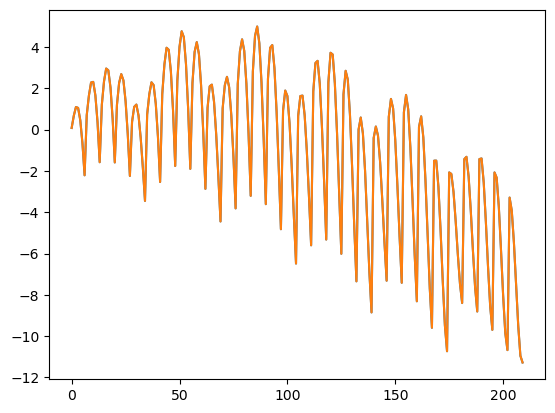

In [18]:
plt.plot(result_3d)
plt.plot(result_3d_fft.reshape(-1,))

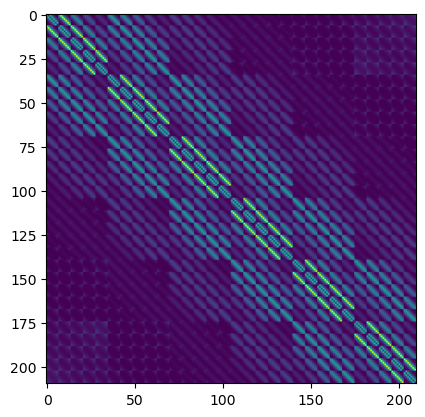

In [19]:
plt.imshow(g_array_3d.real)

# Проверка эквивалентности операторов

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp

def binomial_coeff(n):
    return (n**2 + n)//2

In [21]:
def make_grid(N, L, center, **kwargs):
    # Границы сетки
    x = np.linspace(-L[0]/2 - center[0], L[0]/2 - center[0], N[0] + 1)
    y = np.linspace(-L[1]/2 - center[1], L[1]/2 - center[1], N[1] + 1)
    z = np.linspace(-L[2]/2 - center[2], L[2]/2 - center[2], N[2] + 1)
    
    # Объем ячейки
    h_x = x[1] - x[0]
    h_y = y[1] - y[0]
    h_z = z[1] - z[0]
    volume = h_x * h_y * h_z
    
    # Середины - точки коллокации
    x = (x[1:] + x[:-1])/2
    y = (y[1:] + y[:-1])/2
    z = (z[1:] + z[:-1])/2
    
    # Сетка - трехмерный тензор
    grid_mesh = np.stack(np.meshgrid(x,y,z), axis=-1)
    #grid = np.stack([grid_mesh[1], grid_mesh[0], grid_mesh[2]], axis=-1)
    grid = grid_mesh.reshape(-1, 3)
    
    return grid, volume

In [22]:
def step_dielectric_3d(grid,
                       eps_real,
                       eps_imag,
                       x1_bounds,
                       x2_bounds,
                       x3_bounds):
    """
    grid - Тензор (n_1, n_2, n_3, 3) для каждой точки пространства
    eps_real
    """
    if eps_real is None:
        eps_real = [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]]
    if eps_imag is None:
        eps_imag = [[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0]]
    if x1_bounds is None:
        x1_bounds = [-1.0, 0.5]
    if x2_bounds is None:
        x2_bounds = [-1.0, 1.0]
    if x3_bounds is None:
        x3_bounds = [-1.0, 1.0]

    eps = np.zeros((grid.shape[0])) + 0.0j
    indexes = ((grid[:, 0] >= x1_bounds[0]) * (grid[:, 0] <= x1_bounds[1]) *
               (grid[:, 1] >= x2_bounds[0]) * (grid[:, 1] <= x2_bounds[1]) *
               (grid[:, 2] >= x3_bounds[0]) * (grid[:, 2] <= x3_bounds[1]))
    eps[indexes] = np.array(eps_real) + 1j * np.array(eps_imag)
    return eps, indexes


def ellipsis_dielectric_3d(grid,
                           eps_real,
                           eps_imag,
                           center,
                           radius):
    if eps_real is None:
        eps_real = [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]]
    if eps_imag is None:
        eps_imag = [[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0]]
    if center is None:
        center = [0.0, 0.0, 0.0]
    if radius is None:
        radius = [1.0, 1.0, 1.0]
    eps = np.zeros((grid.shape[0])) + 0j
    indexes = (
        ((grid[:, 0] - center[0]) ** 2) / (radius[0] ** 2) +
        ((grid[:, 1] - center[1]) ** 2) / (radius[1] ** 2) +
        ((grid[:, 2] - center[2]) ** 2) / (radius[2] ** 2)
    ) <= 1
    eps[indexes] = np.array(eps_real) + 1j * np.array(eps_imag)
    return eps, indexes


def apply_dielectric_3d(grid,
                        eps_vec=None, **kwargs):
    if eps_vec is None:
        eps_vec = [
            {
                "type": "step",
                "eps_real": 1.0,
                "eps_imag": 0.0,
                "x1_bounds": [-1.0, 0.0],
                "x2_bounds": [-1.0, 1.0],
                "x3_bounds": [-1.0, 1.0]
            },
            {
                "type": "ellipsis",
                "eps_real": 1.0,
                "eps_imag": 0.0,
                "center": [0.0, 0.0, 0.0],
                "radius": [1.0, 1.0, 1.0]
            }
        ]

    eps = np.zeros((grid.shape[0])) + 0j
    indexes = np.zeros(grid.shape[0], dtype=bool)
    for num, element in enumerate(eps_vec):
        if element.get("type") == "step":
            eps_d, indexes_d = step_dielectric_3d(grid=grid,
                                                  eps_real=element.get('eps_real'),
                                                  eps_imag=element.get('eps_imag'),
                                                  x1_bounds=element.get('x1_bounds'),
                                                  x2_bounds=element.get('x2_bounds'),
                                                  x3_bounds=element.get('x3_bounds'))
        elif element.get("type") == "ellipsis":
            eps_d, indexes_d = ellipsis_dielectric_3d(grid=grid,
                                                      eps_real=element.get('eps_real'),
                                                      eps_imag=element.get('eps_imag'),
                                                      center=element.get('center'),
                                                      radius=element.get('radius'))
        else:
            continue
        indexes += indexes_d
        eps += eps_d
    return eps, indexes

In [23]:
def kernel(x, k=1, **kwargs):
    return np.exp(1j * k * x)/(4 * np.pi * x)

In [24]:
def wave(x, k=1, orient=[1.0, 1.0, 1.0], sign=1, amplitude=1.0, **kwargs):
    orient = np.array(orient) / np.linalg.norm(np.array(orient), 2)
    return amplitude * np.exp(sign * 1j * k * (x.dot(orient)))

In [25]:
def fast_bbtmv_mul(col_arr,
                   row_arr,
                   vec_arr,
                   n, m, k):
    """

    :param col_arr:
    :param row_arr:
    :param vec_arr:
    :param n:
    :param m:
    :param k:
    :return:
    """
    circulant_tensor = np.zeros((2 * n, 2 * m, 2 * k)) + 0.0j
    x_arr = np.zeros((2 * n, 2 * m, 2 * k)) + 0.0j

    circulant_tensor[:n, :m, :k] = row_arr[:n, :m, :k]
    circulant_tensor[n + 1:2 * n, :m, :k] = col_arr[n:0:-1, :m, :k]
    circulant_tensor[:n, m + 1:2 * m, :k] = col_arr[:n, m:0:-1, :k]
    circulant_tensor[:n, :m, k + 1: 2 * k] = col_arr[:n, :m, k:0:-1]
    circulant_tensor[n + 1:2 * n, m + 1:2 * m, :k] = col_arr[n:0:-1, m:0:-1, :k]
    circulant_tensor[:n, m + 1:2 * m, k + 1:2 * k] = col_arr[:n, m:0:-1, k:0:-1]
    circulant_tensor[n + 1:2 * n, :m, k + 1:2 * k] = col_arr[n:0:-1, :m, k:0:-1]
    circulant_tensor[n + 1:2 * n, m + 1:2 * m, k + 1:2 * k] = col_arr[n:0:-1, m:0:-1, k:0:-1]

    x_arr[:n, :m, :k] = vec_arr[:n, :m, :k]

    circulant_tensor = np.fft.fftn(circulant_tensor) * np.fft.fftn(x_arr)
    circulant_tensor = np.fft.ifftn(circulant_tensor)

    return circulant_tensor[:n, :m, :k]


def prep_fftbbtensor(col_arr,
                     row_arr,
                     n, m, k):
    """

    """
    circulant_tensor = np.zeros((2 * n, 2 * m, 2 * k)) + 0.0j
    col_arr = col_arr.reshape((n, m, k))
    row_arr = row_arr.reshape((n, m, k))
    circulant_tensor[:n, :m, :k] = row_arr[:n, :m, :k]
    circulant_tensor[n + 1:2 * n, :m, :k] = col_arr[n:0:-1, :m, :k]
    circulant_tensor[:n, m + 1:2 * m, :k] = col_arr[:n, m:0:-1, :k]
    circulant_tensor[:n, :m, k + 1: 2 * k] = col_arr[:n, :m, k:0:-1]
    circulant_tensor[(n + 1):(2 * n), (m + 1):(2 * m), :k] = col_arr[n:0:-1, m:0:-1, :k]
    circulant_tensor[:n, (m + 1):(2 * m), (k + 1):(2 * k)] = col_arr[:n, m:0:-1, k:0:-1]
    circulant_tensor[(n + 1):(2 * n), :m, (k + 1):(2 * k)] = col_arr[n:0:-1, :m, k:0:-1]
    circulant_tensor[(n + 1):(2 * n), (m + 1):(2 * m), (k + 1):(2 * k)] = col_arr[n:0:-1, m:0:-1, k:0:-1]
    circulant_tensor = np.fft.fftn(circulant_tensor)
    return circulant_tensor


def prep_fbbtmv(prep_fft_arr,
                vec_arr,
                n, m, k):
    """
    """
    x_arr = np.zeros((2 * n, 2 * m, 2 * k)) + 0.0j
    x_arr[:n, :m, :k] = vec_arr[:n, :m, :k]
    prep_fft_arr = np.fft.ifftn(prep_fft_arr * np.fft.fftn(x_arr))
    return prep_fft_arr[:n, :m, :k]

In [26]:
def operator(operator_array, vector_array, nu, n_1, n_2, n_3):
    result = np.zeros((n_1 * n_2 * n_3, )) + 0.0j
    vec_array = nu * vector_array
    result = fast_bbtmv_mul(operator_array.reshape(n_1, n_2, n_3),
                            operator_array.reshape(n_1, n_2, n_3),
                            vec_array.reshape((n_1, n_2, n_3)),
                            n_1, n_2, n_3).reshape(-1,)
    result = vector_array - result
    return result

def conj_operator(conj_operator, vector_array, nu, n_1, n_2, n_3):
    result = np.zeros((n_1 * n_2 * n_3, )) + 0.0j
    result = np.conj(nu) * fast_bbtmv_mul(conj_operator.reshape(n_1, n_2, n_3), 
                                          conj_operator.reshape(n_1, n_2, n_3), 
                                          vector_array.reshape((n_1, n_2, n_3)), 
                                          n_1, n_2, n_3).reshape(-1,)
    result = vector_array - result
    return result

In [27]:
problem_config = {
    'N': [6, 10, 8],
    'L': [2.0, 2.0, 2.0],
    'center': [0.0, 0.0, 0.0],
    'k': 5.0,
    'orient': [1.0, 1.0, 1.0],
    'amplitude': 1.0,
    'sign': 1.0,
    'eps_vec': [
        {
            "type": "step",
            "eps_real": 1.0,
            "eps_imag": 0.0,
            "x1_bounds": [-2.0, 2.0],
            "x2_bounds": [-2.0, 2.0],
            "x3_bounds": [-2.0, 2.0]
        },
        {
            "type": "step",
            "eps_real": 0.0,
            "eps_imag": 0.0,
            "x1_bounds": [-0.5, 0.5],
            "x2_bounds": [-2.0, 2.0],
            "x3_bounds": [-2.0, 2.0]
        },
        {
            "type": "ellipsis",
            "eps_real": 10.0,
            "eps_imag": 2.0,
            "center": [0.0, 0.0, 0.0],
            "radius": [1.0, 1.0, 1.0]
        }
    ]
}

n_1 = problem_config.get('N')[0]
n_2 = problem_config.get('N')[1]
n_3 = problem_config.get('N')[2]

In [28]:
# Трехмерная сетка
grid, volume = make_grid(**problem_config)

print("Размерность сетки", grid.shape)
print("Объем ячейки", round(volume, 6))

Размерность сетки (480, 3)
Объем ячейки 0.016667


In [29]:
# Индекс рефракции среды, определенный в точках сетки
eta, indexes = apply_dielectric_3d(grid, **problem_config)
eta.shape

(480,)

In [30]:
# Внешняя волна, определенная в точках сетки
f_wave = wave(grid, **problem_config)
power_f = np.sum(np.abs(f_wave))/f_wave.size

print("Количество значений на сетке", f_wave.shape)
print("Мощность волны", power_f)


Количество значений на сетке (480,)
Мощность волны 1.0


In [31]:
# Определение массива дисркетизированного ядра оператора
dists = np.sqrt(np.sum((grid[0] - grid[:])**2, axis = 1))
dists[0] = 10e-8
dists

array([1.00000000e-07, 2.50000000e-01, 5.00000000e-01, 7.50000000e-01,
       1.00000000e+00, 1.25000000e+00, 1.50000000e+00, 1.75000000e+00,
       3.33333333e-01, 4.16666667e-01, 6.00925213e-01, 8.20738150e-01,
       1.05409255e+00, 1.29368122e+00, 1.53659074e+00, 1.78146319e+00,
       6.66666667e-01, 7.12000312e-01, 8.33333333e-01, 1.00346621e+00,
       1.20185043e+00, 1.41666667e+00, 1.64147630e+00, 1.87268375e+00,
       1.00000000e+00, 1.03077641e+00, 1.11803399e+00, 1.25000000e+00,
       1.41421356e+00, 1.60078106e+00, 1.80277564e+00, 2.01556444e+00,
       1.33333333e+00, 1.35656838e+00, 1.42400062e+00, 1.52979665e+00,
       1.66666667e+00, 1.82764268e+00, 2.00693243e+00, 2.20006313e+00,
       1.66666667e+00, 1.68531237e+00, 1.74005108e+00, 1.82764268e+00,
       1.94365063e+00, 2.08333333e+00, 2.24227067e+00, 2.41666667e+00,
       2.00000000e-01, 3.20156212e-01, 5.38516481e-01, 7.76208735e-01,
       1.01980390e+00, 1.26589889e+00, 1.51327460e+00, 1.76139150e+00,
      

In [32]:
# Заполнение первой строки матрицы 
G_array = kernel(dists, **problem_config) * volume
G_array[0] = 0
G_array

array([ 0.00000000e+00+0.00000000e+00j,  1.67283709e-03+5.03451977e-03j,
       -2.12509944e-03+1.58749667e-03j, -1.45106753e-03-1.01074232e-03j,
        3.76218658e-04-1.27181282e-03j,  1.06044877e-03-3.52042421e-05j,
        3.06492913e-04+8.29374072e-04j, -5.91787859e-04+4.73466216e-04j,
       -3.80871896e-04+3.96060242e-03j, -1.56095932e-03+2.77408082e-03j,
       -2.18641204e-03+3.01352204e-04j, -9.24013681e-04-1.32573354e-03j,
        6.66299907e-04-1.06732747e-03j,  1.00767157e-03+1.88805809e-04j,
        1.46902231e-04+8.50545964e-04j, -6.47024197e-04+3.68284023e-04j,
       -1.95297838e-03-3.79122916e-04j, -1.70207898e-03-7.56855799e-04j,
       -8.26070854e-04-1.36038103e-03j,  3.96827448e-04-1.26073190e-03j,
        1.06239472e-03-2.98529960e-04j,  6.52161266e-04+6.71689296e-04j,
       -2.79635800e-04+7.58054416e-04j, -7.06897394e-04+4.34291668e-05j,
        3.76218658e-04-1.27181282e-03j,  5.49790173e-04-1.16331666e-03j,
        9.12625635e-04-7.57860879e-04j,  1.06044877

In [33]:
from_x = -1
to_x = 1
from_y = -1
to_y = 1
from_z = -1
to_z = 1
n_x = 6
n_y = 10
n_z = 8

grid_x = np.linspace(from_x, to_x, n_x+1)
grid_y = np.linspace(from_y, to_y, n_y+1)
grid_z = np.linspace(from_z, to_z, n_z+1)


grid_x = (grid_x[1:] + grid_x[:-1])/2
grid_y = (grid_y[1:] + grid_y[:-1])/2
grid_z = (grid_z[1:] + grid_z[:-1])/2

grid_3d = np.stack(np.meshgrid(grid_x, grid_y, grid_z), axis=-1)
grid_3d = grid_3d.reshape(-1, 3, order="C")
print(grid_3d.shape)

(480, 3)


In [34]:
g_array_3d = np.zeros((n_x*n_y*n_z, n_x*n_y*n_z)) + 0.0j

k=5
orient = (1.0, 1.0, 1.0)

for i in range(n_x  * n_y * n_z - 1):
    for j in range(i+1, n_x * n_y * n_z):
        g_array_3d[i, j] = kernel(np.sqrt(np.sum((grid_3d[i] - grid_3d[j])**2)), k) * volume
        g_array_3d[j, i] = kernel(np.sqrt(np.sum((grid_3d[j] - grid_3d[i])**2)), k) * volume
        
f_wave_3d = wave(grid_3d, k, orient, 1, 1)

In [35]:
g_array_3d[0, :] - G_array

array([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
      

In [36]:
result_3d = g_array_3d @ f_wave_3d
result_3d_fft = fast_bbtmv_mul(col_arr = G_array.reshape(n_y, n_x, n_z), 
                               row_arr = G_array.reshape(n_y, n_x, n_z), 
                               vec_arr = f_wave_3d.reshape(n_y, n_x, n_z), 
                               n = n_y, m = n_x, k = n_z)

np.sum(np.abs(result_3d - result_3d_fft.reshape(-1,)))

3.746713039813756e-14

In [37]:
result_oper_3d = f_wave_3d - g_array_3d @ (f_wave_3d * eta)
result_oper_fft_3d = operator(G_array, f_wave_3d, eta, n_2, n_1, n_3)

In [38]:
np.sum(np.abs(result_oper_3d - result_oper_fft_3d))

3.10716933982401e-13

In [39]:
result_oper_3d = f_wave_3d - np.conj(eta) * (np.conj(g_array_3d).T @ f_wave_3d)
result_oper_fft_3d = conj_operator(np.conj(G_array), f_wave_3d, eta, n_2, n_1, n_3)

In [40]:
np.sum(np.abs(result_oper_3d - result_oper_fft_3d))

2.1279704099929867e-13